In [3]:
import cv2
import sys
import numpy as np
import keras

from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, LSTM, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

!pip install mediapipe
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()


Mounted at /content/drive


In [5]:
def extract_landmarks_from_video(video_path):
    """Extract pose landmarks from a video using MediaPipe, using every third frame."""
    cap = cv2.VideoCapture(video_path)
    landmarks_list = []
    frame_count = 0  # Frame counter

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 3 != 0:  # Skip every third frame
            frame_count += 1
            continue
        frame_resized = cv2.resize(frame, (160, 120))
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            landmarks = [[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark]
            landmarks_list.append(landmarks)

        frame_count += 1  # Increment frame counter
    print(f"Extracted landmarks from {frame_count} frames.")
    cap.release()
    return np.array(landmarks_list)

def preprocess_landmarks(landmarks):
    """Normalize landmarks for scale invariance."""
    landmarks = np.array(landmarks)
    if landmarks.ndim == 3:
        landmarks[:, :, :3] -= np.mean(landmarks[:, :, :3], axis=1, keepdims=True)
        landmarks[:, :, :3] /= np.std(landmarks[:, :, :3], axis=1, keepdims=True)
    return landmarks


def save_landmarked_video(video_path, save_path):
    """Save a video with pose landmarks drawn."""
    cap = cv2.VideoCapture(video_path)
    out = None
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    if save_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(save_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break


        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
            )

        if out:
            out.write(frame)

    cap.release()
    if out:
        out.release()
    print(f"\nLandmarked video saved at {save_path}")



In [ ]:
def augment_landmarks(landmarks_list):
    """Apply augmentation to landmarks with a 50% chance for each type."""
    augmented_list = []

    for landmarks in landmarks_list:
        augmented = landmarks.copy()

        # Randomly apply horizontal flip
        if np.random.rand() < 0.5:
            augmented[:, :, 0] = -augmented[:, :, 0]  # Flip x-coordinates

        # Randomly apply noise
        if np.random.rand() < 0.5:
            noise = np.random.normal(0, 0.02, size=augmented[:, :, :3].shape)
            augmented[:, :, :3] += noise

        augmented_list.append(augmented)

    return augmented_list

def augment_raw_video(frames, flip_prob=0.5, noise_prob=0.5):
    """
    Augments raw video frames with horizontal flipping and random noise.

    Args:
        frames (list or np.array): List of video frames (shape: [num_frames, height, width, channels]).
        flip_prob (float): Probability of applying horizontal flip.
        noise_prob (float): Probability of applying noise.

    Returns:
        augmented_frames (np.array): Augmented frames.
    """
    augmented_frames = []

    for frame in frames:
        augmented_frame = frame.copy()

        # Randomly apply horizontal flip
        if np.random.rand() < flip_prob:
            augmented_frame = cv2.flip(augmented_frame, 1)

        # Randomly apply noise
        if np.random.rand() < noise_prob:
            noise = np.random.normal(0, 25, augmented_frame.shape).astype(np.uint8)  # Adjust noise intensity
            augmented_frame = cv2.add(augmented_frame, noise)

        augmented_frames.append(augmented_frame)

    return np.array(augmented_frames)

def save_augmented_examples(video_path, output_flip_path, output_noise_path):
    """Save the first processed video with horizontal flip and noise applied."""
    cap = cv2.VideoCapture(video_path)

    # Define video writer properties
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create writers for flipped and noisy videos
    flip_writer = cv2.VideoWriter(output_flip_path, fourcc, fps, (frame_width, frame_height))
    noise_writer = cv2.VideoWriter(output_noise_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Apply horizontal flip
        flipped_frame = cv2.flip(frame, 1)

        # Apply noise
        noise = np.random.normal(0, 25, frame.shape).astype(np.uint8)  # Adjust noise intensity
        noisy_frame = cv2.add(frame, noise)

        # Write augmented frames to respective videos
        flip_writer.write(flipped_frame)
        noise_writer.write(noisy_frame)

    # Release resources
    cap.release()
    flip_writer.release()
    noise_writer.release()

    print(f"Saved horizontally flipped video to {output_flip_path}")
    print(f"Saved noisy video to {output_noise_path}\n")


In [15]:
def create_LSTM_model(input_shape, dropout_rate=0.5):
    """Create an LSTM model for video classification."""
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=input_shape),  # input_shape is (sequence_length, features)
        Dropout(dropout_rate),
        #LSTM(128, return_sequences=False),
        #Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model


In [22]:
def load_data(video_folder, use_landmarking=True, use_augmentation=True):
    """Load video data and corresponding labels."""
    videos = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.mp4')]
    videos.sort()
    print(videos)
    sequences = []
    labels = []
    first = True
    for idx, video in enumerate(videos):
        sys.stdout.write(f"\rProcessing video {idx + 1}/{len(videos)}: {os.path.basename(video)}")
        sys.stdout.flush()

        if (("Jasmun" in os.path.basename(video)) or ("Fake" in os.path.basename(video)) or ("Take" in os.path.basename(video)) or ("noperson" in os.path.basename(video))):
            continue
            #labels.append(0)
        elif "No_Pill" in os.path.basename(video):
            labels.append(0)
        else:
            labels.append(1)


        if use_landmarking:
          landmarks = extract_landmarks_from_video(video)
          if first:
              save_landmarked_video(video, '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Example_LandMarked_Video.mp4')
              first = False

          landmarks = preprocess_landmarks(landmarks)
          print(f"Landmarks shape: {landmarks.shape}")
          sequences.append(landmarks)
          #print(f"Sequence shape: {np.array(sequences).shape}")


          if use_augmentation:
            if idx == 0:
              save_augmented_examples(video, '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Example_Flipped_Video.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Example_Noisy_Video.mp4')
            augmented_landmarks_list = augment_landmarks([landmarks])
            for augmented_landmarks in augmented_landmarks_list:
                sequences.append(augmented_landmarks)
                labels.append(labels[-1])  # Duplicate the label


        else:
          # Load raw video frames as input
          cap = cv2.VideoCapture(video)
          frames = []
          scaler = StandardScaler()

          while cap.isOpened():
              ret, frame = cap.read()
              if not ret:
                  break

              # Resize frame to consistent dimensions (e.g., 224x224)
              frame_resized = cv2.resize(frame, (224, 224))

              # Flatten frame for scaling, normalize, and reshape back
              frame_flattened = frame_resized.reshape(-1, 3)  # Flatten while keeping RGB channels
              frame_normalized = scaler.fit_transform(frame_flattened).reshape(frame_resized.shape)

              frames.append(frame_normalized)
          cap.release()

          if use_augmentation:
                frames = augment_raw_video(frames)
          sequences.append(np.array(frames))


    # Pad sequences to the maximum length

    max_length = max([seq.shape[0] for seq in sequences]) if sequences else 0
    max_length = 200
    print(f"Maximum sequence length: {max_length}")
    if use_landmarking:
        padded_shape = (len(sequences), max_length, 33, 4)  # For landmarks
    else:
        padded_shape = (len(sequences), max_length, 224, 224, 3)  # For raw video frames

    sequences_padded = np.zeros(padded_shape, dtype=np.float32)
    for i, seq in enumerate(sequences):
        sequences_padded[i, :seq.shape[0], ...] = seq

    return sequences_padded, labels

In [33]:
def main(X, y, video_folder, use_landmarking=True, model_save_path='/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/pill_classifier_weighted2.keras'):
    """Main function to train and test the model."""


    if use_landmarking:
      max_length, num_features = X.shape[1], X.shape[2] * X.shape[3]
      X = X.reshape((X.shape[0], max_length, num_features))
    else:
      max_length, num_features = X.shape[1], X.shape[2]* X.shape[3]* X.shape[4]
      X = X.reshape((X.shape[0], max_length, num_features))


    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    from sklearn.utils.class_weight import compute_class_weight

    # Compute class weights with a bias toward class 0
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Increase weight for class 0
    class_weight_dict[0] *= 4  # Adjust the factor as needed to increase bias toward class 0

    # Train model with class weighting
    model = keras.saving.load_model('/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/pill_classifier_Final.keras')

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=10, batch_size=1, shuffle=True,
                        class_weight=class_weight_dict)

    #del model
    '''
    model = create_LSTM_model((max_length, 33*4))

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=300, batch_size=1, shuffle=True)
    '''
    #Save the model
    model.save(model_save_path)
    print(f"\n Model saved to {model_save_path}")

    return model, history, X_test, y_test

if __name__ == '__main__':
    # Define paths
    video_folder = '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos'  # Folder containing video files

    #keras.backend.clear_session()

    # Load data and labels
    #X, y = load_data(video_folder, use_landmarking=True, use_augmentation=False)
    print(X.shape)
    # Train the model
    model, history, X_test, Y_test = main(X, y, video_folder, use_landmarking=True)

(231, 200, 33, 4)
Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 4.3642e-05 - val_accuracy: 0.8000 - val_loss: 2.4742
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 3.4072e-05 - val_accuracy: 0.8000 - val_loss: 2.5285
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 3.4553e-05 - val_accuracy: 0.8000 - val_loss: 2.5531
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 5.0707e-05 - val_accuracy: 0.8000 - val_loss: 2.5608
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 5.4758e-05 - val_accuracy: 0.8000 - val_loss: 2.5598
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 1.4238e-05 - val_accuracy: 0.8000 - val_loss: 2.5834
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 3.9302e-05 - val_accuracy: 0.8000 - val_loss: 2.6273
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/ste

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8141 - loss: 2.5620 
Test Loss: 2.622213840484619, Test Accuracy: 0.800000011920929
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


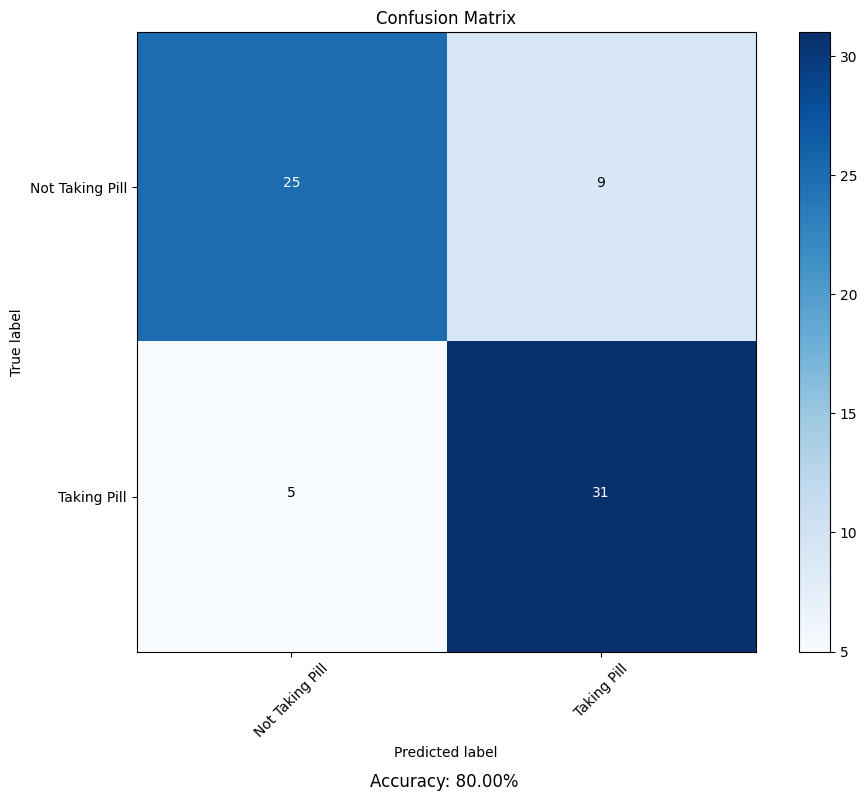

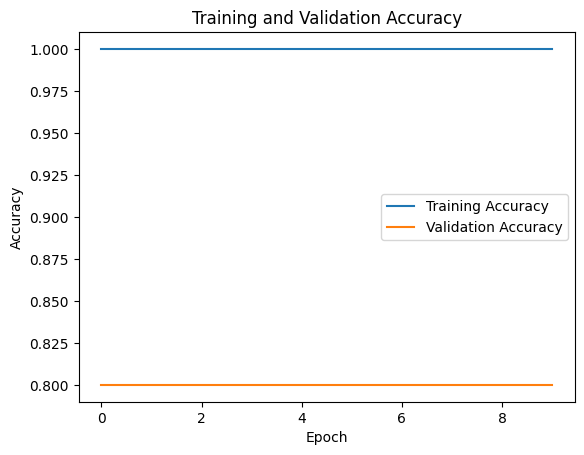

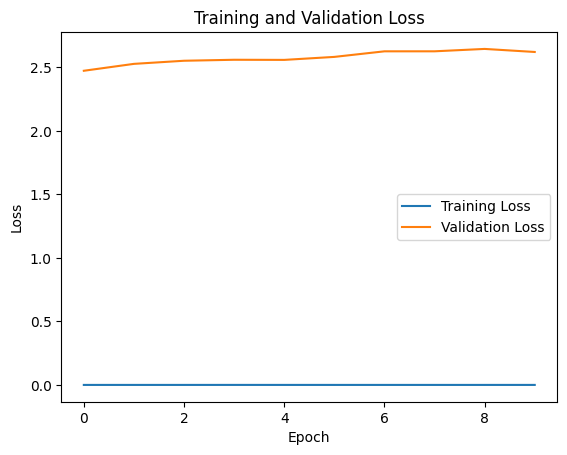

In [34]:

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Predict the labels for the test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Define the save path
#save_path = '/content/drive/MyDrive/Josh/Results/LSTM-Tuning/Stride-Variation-Test/FullSegment'

# Compute and plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)  # Adjust this to the number of classes
class_labels = ["Not Taking Pill", "Taking Pill"]
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate the confusion matrix
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
accuracy = test_acc * 100

# Overlay accuracy and voted accuracy below the plot
plt.figtext(0.5, 0.01, f"Accuracy: {accuracy:.2f}%",
            fontsize=12, color="black", horizontalalignment='center')

# Finalize the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for text
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))  # Save figure
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
#plt.savefig(os.path.join(save_path, 'accuracy_plot.png'))  # Save figure
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig(os.path.join(save_path, 'loss_plot.png'))  # Save figure
plt.show()

In [ ]:
video_folder = '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos'
videos = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.mp4')]
videos.sort()
print(videos)

max_length = 200  # Fixed sequence length for padding

for idx, video in enumerate(videos):
    sys.stdout.write(f"\rProcessing video {idx + 1}/{len(videos)}: {os.path.basename(video)}")
    sys.stdout.flush()

    # Extract landmarks for the entire video (returns an array of shape (frames, 33, 4))
    landmarks = extract_landmarks_from_video(video)
    landmarks = preprocess_landmarks(landmarks)

    # Ensure uniform length with padding/truncation
    sequence_length = min(len(landmarks), max_length)
    sequences_padded = np.zeros((max_length, 33, 4), dtype=np.float32)  # No (1, ...), just (max_length, 33, 4)

    # Copy valid frames
    sequences_padded[:sequence_length, ...] = landmarks[:sequence_length, ...]

    print(f"\nInput shape for model: {sequences_padded.shape}")  # Should be (200, 33, 4)

    sequences_padded = sequences_padded.reshape((1, max_length, 33*4))

    print(f"\nInput shape for model: {sequences_padded.shape}")  # Should be (200, 33, 4)

    # Make predictions (assuming model expects batch input)
    prediction = (model.predict(sequences_padded) > 0.5).astype(int)
    print(os.path.basename(video), ": ", prediction)

['/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_1.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_10.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_11.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_12.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_13.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_14.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_15.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_16.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_17.mp4', '/content/drive/MyDrive/5th_Year/Capstone/Computer_Vision/Pill_Prediction_Videos/Fake_Pill_18.mp4', 